Data - https://www.kaggle.com/c/bike-sharing-demand/data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import r2_score

In [2]:
train=pd.read_csv('/Users/aleksandr/Desktop/demand/train.csv')
df=train.copy()
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Features description**

datetime - hourly date + timestamp  


season -  1 = spring, 2 = summer, 3 = fall, 4 = winter



holiday - whether the day is considered a holiday


workingday - whether the day is neither a weekend nor holiday



weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 


2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 


3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 


4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 


temp - temperature in Celsius


atemp - "feels like" temperature in Celsius


humidity - relative humidity


windspeed - wind speed


casual - number of non-registered user rentals initiated


registered - number of registered user rentals initiated


**count - number of total rentals** - Dependent Var



In [3]:
df.shape

(10886, 12)

In [4]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


So to build a regression model, we should check our data according to regression assumptions:

we do not need highly correlated variables 

we do not need not normally distributed y variable (count)

we do not need outliers

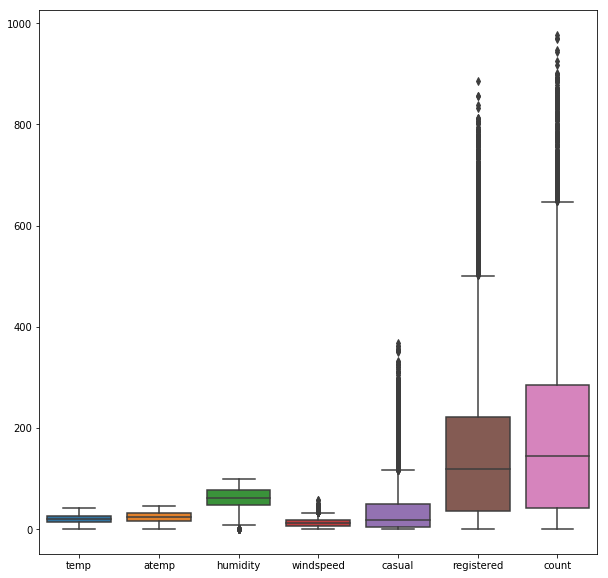

In [5]:
#variables visualization, 
sns.boxplot(data=df[['temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']])
fig=plt.gcf()
fig.set_size_inches(10,10)

Boxplots shows there are variables with distribution we do not need.
Main problem is with our dependent variable.

In [6]:
#here i am trying to remove outliers from count
df = df[np.abs(df["count"]-df["count"].mean())<=(3*df["count"].std())] 

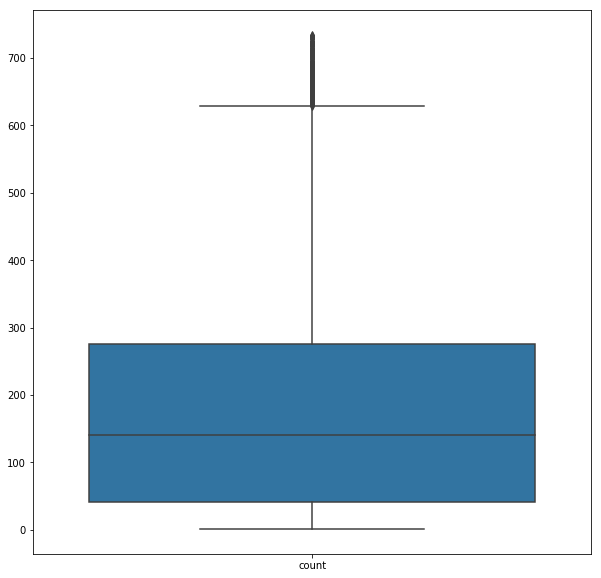

In [7]:
#this boxplot looks better
sns.boxplot(data=df[['count']])
fig=plt.gcf()
fig.set_size_inches(10,10)

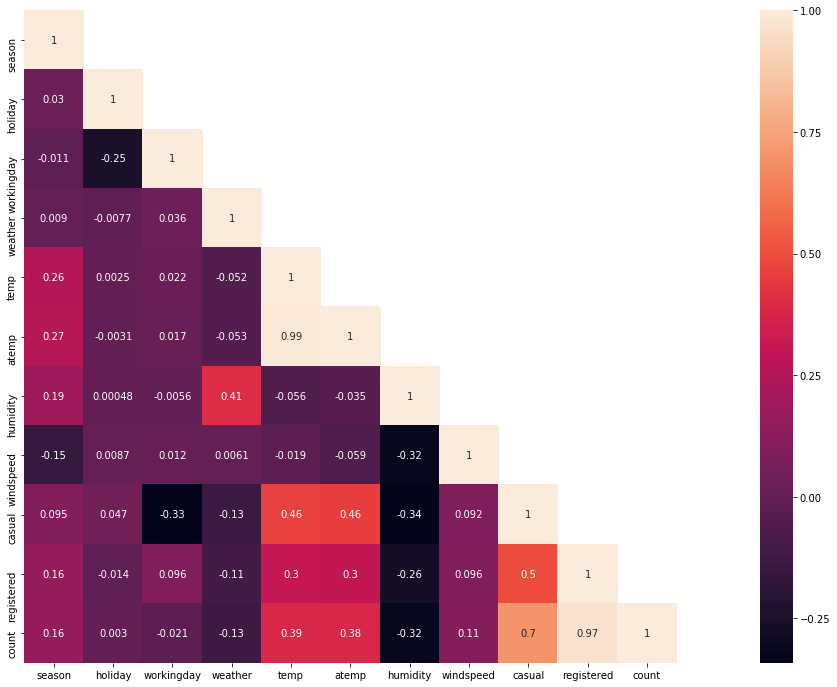

In [8]:
#looking for correlated variables 
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [9]:
# here we also have a problem with datatime variable
# we should recode it to have separate hours, dates, etc
df["hour"] = [t.hour for t in pd.DatetimeIndex(df.datetime)]
df["month"] = [t.month for t in pd.DatetimeIndex(df.datetime)]
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1


In [10]:
#after recoding we can drop initial variable
df.drop('datetime',axis=1,inplace=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1


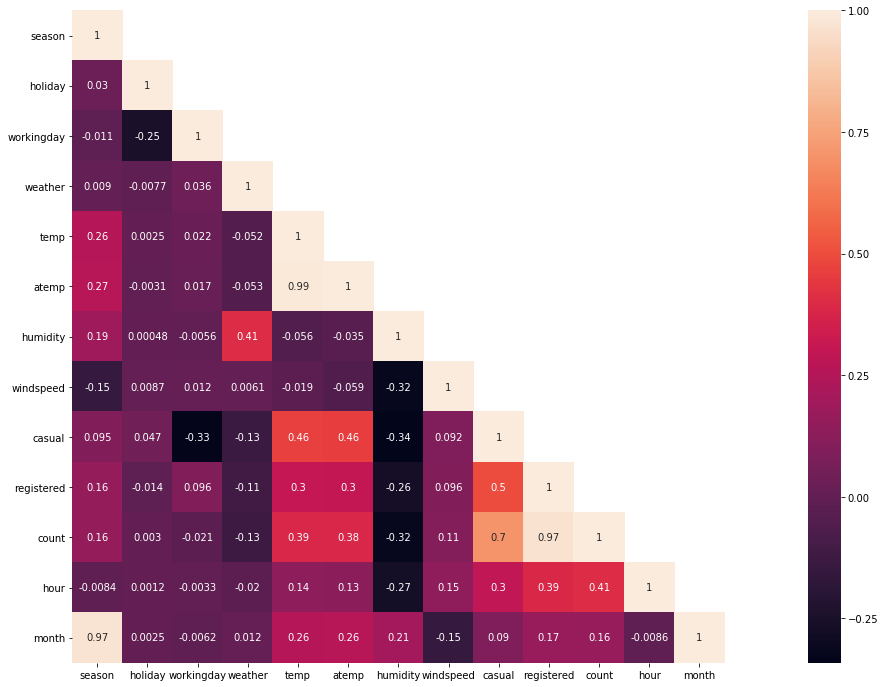

In [11]:
#look at correlations again after we change some variables 
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [12]:
# month and session are also highly correlated as well as temp/atemp, casual/count, 
# so i will drop them 
df.drop(['casual','season', 'temp'],axis=1,inplace=True)


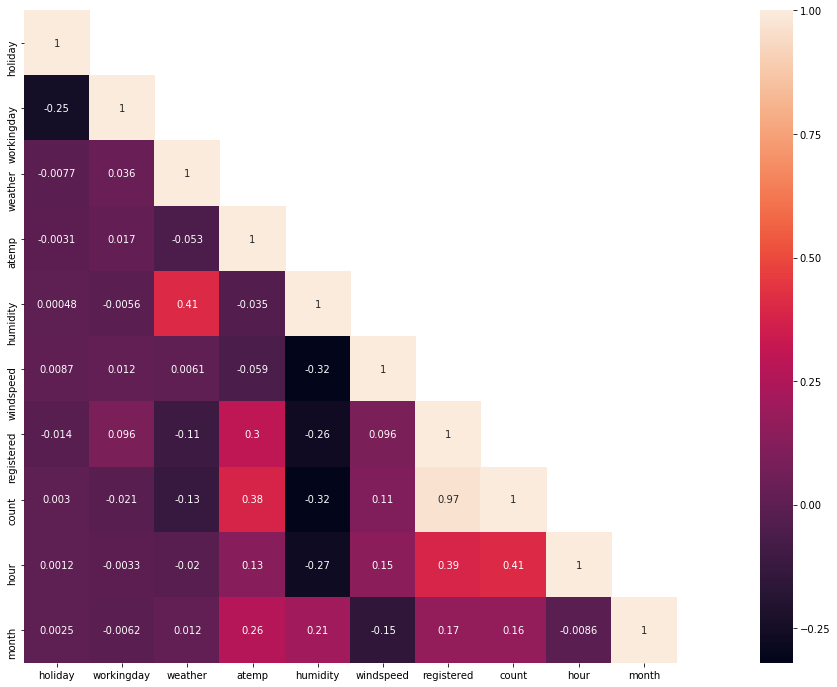

In [13]:
# now looks like it's ok 
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [14]:
# oh i didn't see we also have to drop register cuz it's higlhy correlated with dependent variable

df.drop(['registered'],axis=1,inplace=True)

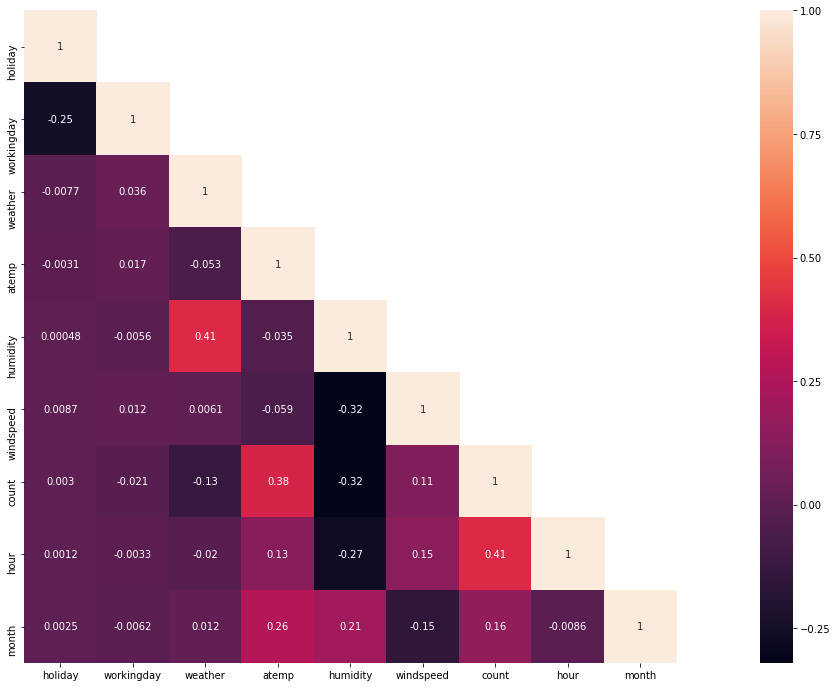

In [15]:
# now i don't see any correlated features
cor_mat= df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [16]:
df.head()

,holiday,workingday,weather,atemp,humidity,windspeed,count,hour,month
0,0,0,1,14.395,81,0.0,16,0,1
1,0,0,1,13.635,80,0.0,40,1,1
2,0,0,1,13.635,80,0.0,32,2,1
3,0,0,1,14.395,75,0.0,13,3,1
4,0,0,1,14.395,75,0.0,1,4,1


the only problem now before i can move to building a model is various datatypes in dataframe

we have binary variables: holiday and working day. 

categorical weather and month

so there a diffetent thing i can do

i will stick to the easiest - i will include only numerical features at first

maybe we will come up to good model


In [17]:
model_data = df.drop(['holiday', 'workingday', 'weather'], axis = 1)

In [18]:
model_data.head()

,atemp,humidity,windspeed,count,hour,month
0,14.395,81,0.0,16,0,1
1,13.635,80,0.0,40,1,1
2,13.635,80,0.0,32,2,1
3,14.395,75,0.0,13,3,1
4,14.395,75,0.0,1,4,1


In [19]:
model_data.shape

(10739, 6)

In [20]:
#now we split data
#our data is already sorted by Kaggle for us by time and we should predict future bikes' demand,
#so its logical to split this way, when we have 'early data' at train and 'late' in test
train_data = model_data.iloc[:-2000, :]
test_data = model_data.iloc[-2000:, :]

In [21]:
train_data.shape
test_data.shape

(2000, 6)

In [22]:
# initaly i have test and train datasets but at first i will just split current dataset for train and test
y_train = train_data['count'].values
X_train = train_data.drop(['count'], axis = 1)

In [23]:
y_test = test_data['count'].values
X_test = test_data.drop(['count'], axis = 1)

In [24]:
#creating model of basic linear regression
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm.intercept_)
print(lm.coef_)


37.736135021597306
[ 6.60452666 -1.82639149  0.31933887  6.60958203  1.53765408]


In [25]:
predictions = lm.predict(X_train)

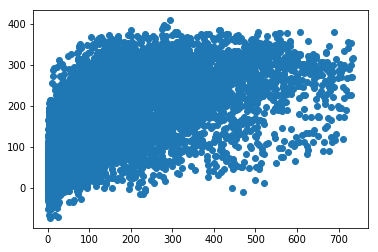

In [26]:
plt.scatter(y_train,predictions)

Text(0.5, 1.0, 'Linear Regression Model')

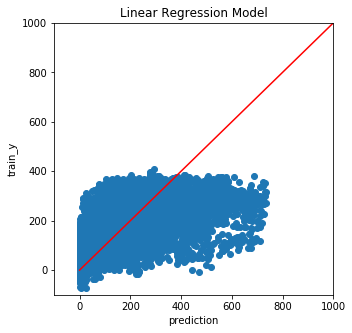

In [27]:
from sklearn import linear_model
plt.figure(figsize=(5, 5))
plt.scatter(y_train,predictions)
plt.plot( [0,1000],[0,1000], color='red')
plt.xlim(-100, 1000)
plt.ylim(-100, 1000)
plt.xlabel('prediction')
plt.ylabel('train_y')
plt.title('Linear Regression Model')

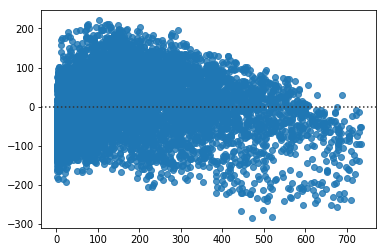

In [28]:
sns.residplot(y_train,predictions)

In [29]:

r2_score(y_train,predictions)

0.3477249295778626

In [30]:
 
metrics.mean_absolute_error(y_train,predictions)

94.82950053654429

Poor model to be honest, r square is bad, and we have mistake of 94 bikes 

I can now try smth else, for example model with stochastic gradient descent

In [31]:
regressor = linear_model.SGDRegressor(random_state = 0)

In [32]:
regressor.fit(X_train, y_train)
metrics.mean_absolute_error(y_train,regressor.predict(X_train))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


2316178598287.6694

Smth strange with errors, i suppose here i need to scale features to get adequate errors

In [33]:
regressor.coef_

array([ 2.97300738e+10,  2.65890902e+10,  1.14643245e+10, -1.04458898e+10,
       -8.42947986e+09])

In [34]:
scaler = StandardScaler()
scaler.fit(X_train, y_train)
scaler_X_train = scaler.transform(X_train)
scaler_X_test = scaler.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [35]:
regressor.fit(scaler_X_train, y_train)
metrics.mean_absolute_error(y_train,regressor.predict(scaler_X_train))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


94.34399273496915

well this is sligtly better then lm model 
maybe i need to try L1/L2 regur. to get better results

In [36]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

lasso = Lasso(alpha=0.1)
lasso.fit(scaler_X_train, y_train)
lasso.coef_

array([ 57.75372062, -35.74584369,   2.56332646,  45.69170851,
         4.84366244])

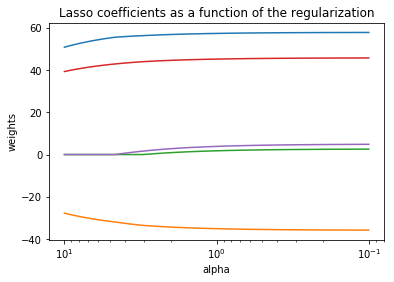

In [37]:
n_alphas = 100
alphas = np.linspace(0.1, 10, n_alphas)
model = Lasso()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(scaler_X_train, y_train)
    coefs.append(model.coef_)
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show();

In [38]:
lasso.coef_

array([ 57.75372062, -35.74584369,   2.56332646,  45.69170851,
         4.84366244])

In [39]:
lasso_cv = LassoCV(alphas=alphas, 
                   cv=3, random_state=17)
lasso_cv.fit(scaler_X_train, y_train)

LassoCV(alphas=array([ 0.1,  0.2, ...,  9.9, 10. ]), copy_X=True, cv=3,
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
    n_jobs=None, normalize=False, positive=False, precompute='auto',
    random_state=17, selection='cyclic', tol=0.0001, verbose=False)

In [40]:
lasso_cv.coef_

array([ 54.91280977, -31.38134396,   0.        ,  42.41037649,
         0.        ])

In [41]:
#well this is what i was asking, im not sure but?
#is this the 'best' alph according to CV and i should add this to final model?
lasso_cv.alpha_

5.3

In [43]:
lasso = Lasso(alpha= 5.3)
lasso.fit(scaler_X_train, y_train)
metrics.mean_absolute_error(y_train,lasso.predict(scaler_X_train))

95.50093706011265

In [44]:
n_alphas = 100
ridge_alphas = np.logspace(-2, 6, n_alphas)
ridge_cv = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_cv.fit(scaler_X_train, y_train)

RidgeCV(alphas=array([1.00000e-02, 1.20450e-02, ..., 8.30218e+05, 1.00000e+06]),
    cv=3, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [45]:
ridge_cv.alpha_

278.2559402207126

In [45]:
ridge_cv.coef_

array([ 56.036467  , -35.05571232,   2.90354063,  44.73543179,
         5.36381911])

In [46]:
ridge = Ridge(alpha=278.2559402207126)
ridge.fit(scaler_X_train, y_train)
metrics.mean_absolute_error(y_train,ridge.predict(scaler_X_train))

94.93003310204497

In [47]:
lm.fit(scaler_X_train, y_train)
metrics.mean_absolute_error(y_train,lm.predict(scaler_X_train))

94.8295005365443

In [48]:
regressor.fit(scaler_X_train, y_train)
metrics.mean_absolute_error(y_train,regressor.predict(scaler_X_train))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


94.34399273496915

So we tried lm model without scaling, SDG model with scaling, Ridge and Lasso with scaling

The lowest error we got is with SDG model

And all errors are rly huge

In [49]:
regressor.fit(scaler_X_test, y_test)
metrics.mean_absolute_error(y_test,regressor.predict(scaler_X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


119.27756106788073

In [50]:
np.mean(y_test)

237.656

Populating the interactive namespace from numpy and matplotlib


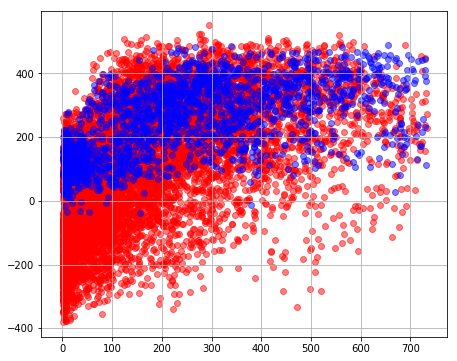

In [51]:
%pylab inline
pylab.figure(figsize = (16,6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(y_train, regressor.predict(scaler_X_train), alpha = 0.5, color = 'red')
pylab.scatter(y_test, regressor.predict(scaler_X_test), alpha = 0.5, color = 'blue')


Well i can say that our prediction is failed. We tried several model and best model we got gave us a mistake of 155 bikes on test data  with 238 bikes avarage of dependent variable

Mb we can try some other options, like Random Forest?


In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
regressor = RandomForestRegressor(random_state = 1)

In [54]:
regressor.fit(scaler_X_train, y_train)
metrics.mean_absolute_error(y_train,regressor.predict(scaler_X_train))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


23.545695404835467

In [55]:
regressor.fit(scaler_X_test, y_test)
metrics.mean_absolute_error(y_test,regressor.predict(scaler_X_test))

28.327998571428573

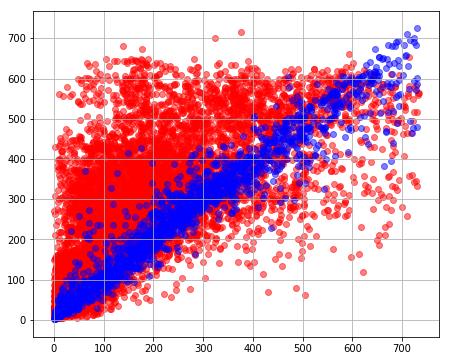

In [56]:
pylab.figure(figsize = (16,6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(y_train, regressor.predict(scaler_X_train), alpha = 0.5, color = 'red')
pylab.scatter(y_test, regressor.predict(scaler_X_test), alpha = 0.5, color = 'blue')


Yes, this is much much better, now we have only 23 and 28 bikes as mistake.

Graph is also looks much better. 

But we still can imporove our model.

As i said at the beggining of model cration, i dropped some non - numerical featuers, as they are not straightforward and i have to recode them somehow.

I will try to add weather here, cuz common sense is telling me weather should be important when we are predicting bikes. 

But the problem is - this is a categorical feature:

1: Clear, Few clouds, Partly cloudy, Partly cloudy

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

So i want to try and recode this as 4 dummy variables

In [57]:
df.head()

,holiday,workingday,weather,atemp,humidity,windspeed,count,hour,month
0,0,0,1,14.395,81,0.0,16,0,1
1,0,0,1,13.635,80,0.0,40,1,1
2,0,0,1,13.635,80,0.0,32,2,1
3,0,0,1,14.395,75,0.0,13,3,1
4,0,0,1,14.395,75,0.0,1,4,1


In [58]:
weather=pd.get_dummies(df['weather'],prefix='weather')
df=pd.concat([df,weather],axis=1)
df.head()


,holiday,workingday,weather,atemp,humidity,windspeed,count,hour,month,weather_1,weather_2,weather_3,weather_4
0,0,0,1,14.395,81,0.0,16,0,1,1,0,0,0
1,0,0,1,13.635,80,0.0,40,1,1,1,0,0,0
2,0,0,1,13.635,80,0.0,32,2,1,1,0,0,0
3,0,0,1,14.395,75,0.0,13,3,1,1,0,0,0
4,0,0,1,14.395,75,0.0,1,4,1,1,0,0,0


In [59]:
df.drop(['weather'], axis = 1)

,holiday,workingday,atemp,humidity,windspeed,count,hour,month,weather_1,weather_2,weather_3,weather_4
0,0,0,14.395,81,0.0000,16,0,1,1,0,0,0
1,0,0,13.635,80,0.0000,40,1,1,1,0,0,0
2,0,0,13.635,80,0.0000,32,2,1,1,0,0,0
3,0,0,14.395,75,0.0000,13,3,1,1,0,0,0
4,0,0,14.395,75,0.0000,1,4,1,1,0,0,0
5,0,0,12.880,75,6.0032,1,5,1,0,1,0,0
6,0,0,13.635,80,0.0000,2,6,1,1,0,0,0
7,0,0,12.880,86,0.0000,3,7,1,1,0,0,0
8,0,0,14.395,75,0.0000,8,8,1,1,0,0,0
9,0,0,17.425,76,0.0000,14,9,1,1,0,0,0


In [60]:
model2 = df

In [61]:
train_data = model2.iloc[:-2000, :]
test_data = model2.iloc[-2000:, :]

In [62]:
y_train = train_data['count'].values
X_train = train_data.drop(['count'], axis = 1)

In [63]:
y_test = test_data['count'].values
X_test = test_data.drop(['count'], axis = 1)

In [64]:
scaler = StandardScaler()
scaler.fit(X_train, y_train)
scaler_X_train = scaler.transform(X_train)
scaler_X_test = scaler.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [65]:
regressor = RandomForestRegressor(random_state = 1)
regressor.fit(scaler_X_train, y_train)
metrics.mean_absolute_error(y_train,regressor.predict(scaler_X_train))



/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15.480943335567432

In [66]:
regressor.fit(scaler_X_test, y_test)
metrics.mean_absolute_error(y_test,regressor.predict(scaler_X_test))

13.832891666666669

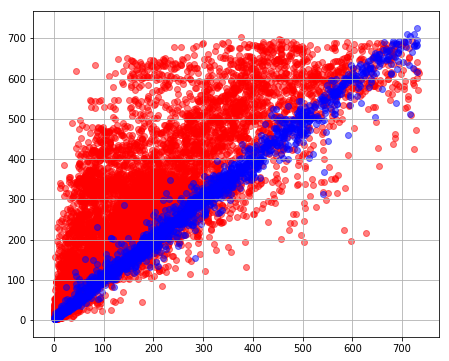

In [67]:
pylab.figure(figsize = (16,6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(y_train, regressor.predict(scaler_X_train), alpha = 0.5, color = 'red')
pylab.scatter(y_test, regressor.predict(scaler_X_test), alpha = 0.5, color = 'blue')